In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lazified_pdap import LazifiedPDAP

# Heat Equation

## Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(kappa(a.reshape(1,-1).T), axis=1)
    norm_kappa = max(vals)
elif Omega.shape[0] == 2:
    x, y = np.meshgrid(a,a)
    points = np.array(list(zip(x.flatten(), y.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals) # ||k([0.5,0.5])||
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals)
else:
    norm_kappa = 10
norm_kappa

6.264527262470839

In [15]:
a = np.arange(0,1,0.1)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(grad_kappa(a.reshape(1,-1).T), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    points = np.array(list(zip(B.flatten(), D.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
else:
    norm_kappa1 = 50
norm_kappa1

27.126794337315015

In [16]:
gamma = 1
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-2
L_H

1.0

## Experiments

In [17]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           norm_kappa1=norm_kappa1,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R
           )

In [18]:
exp.M

259.0174619826847

### PDAP

In [18]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-15)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: Phi:3.290E+03, support: [[0.44043758 0.69141258]], coefs: [1.05279812], x: [0.42427898 0.23939056]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:2: Phi:1.586E+03, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141258]], coefs: [-0.46886794  1.23385151], x: [0.83741191 0.49779621]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:3: Phi:1.290E+03, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141258]
 [0.83741191 0.49779621]], coefs: [-0.53679209  1.13760922  0.3139453 ], x: [0.14118912 0.63968789]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:4: Phi:3.331E+02, support: [[0.14118912 0.63968789

In [19]:
best = objective_values[-1]

In [20]:
np.array(times[:150])

array([2.38418579e-07, 4.74913359e-01, 9.37868595e-01, 1.38820481e+00,
       1.86310196e+00, 2.42706275e+00, 2.89827061e+00, 3.35857606e+00,
       3.80190110e+00, 4.26243949e+00, 4.74094105e+00, 5.24573326e+00,
       5.74106383e+00, 6.22217035e+00, 6.68332148e+00, 7.18561316e+00,
       7.65697718e+00, 8.10074544e+00, 8.54902196e+00, 9.01879621e+00,
       9.47724795e+00, 9.94312000e+00, 1.04049623e+01, 1.09362140e+01,
       1.13948026e+01, 1.18868179e+01, 1.23794615e+01, 1.28269615e+01,
       1.32999799e+01, 1.37942812e+01, 1.42404165e+01, 1.46965971e+01,
       1.51449800e+01, 1.56046414e+01, 1.61094346e+01, 1.65599830e+01,
       1.70004587e+01, 1.74523001e+01, 1.79688554e+01, 1.84535646e+01,
       1.89520309e+01, 1.94039152e+01, 1.98464453e+01, 2.03118050e+01,
       2.07464178e+01, 2.12279112e+01, 2.16971695e+01, 2.21616013e+01,
       2.26089773e+01, 2.30672331e+01, 2.35311906e+01, 2.39961829e+01,
       2.44528053e+01, 2.48939598e+01, 2.53630111e+01, 2.59189491e+01,
      

In [21]:
np.array(supports[:150])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9])

In [22]:
objective_values[:150]-best

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698663e-02, 4.28609944e-02, 2.43456506e-02, 2.24655450e-02,
       2.19692477e-02, 1.97512431e-02, 1.45352926e-02, 1.17524225e-02,
       8.37236219e-03, 8.03803924e-03, 7.27480805e-03, 5.49766940e-03,
       4.74499601e-03, 4.33283626e-03, 3.06984423e-03, 3.03428444e-03,
       2.57014217e-03, 2.25412097e-03, 2.23311015e-03, 1.77761534e-03,
       1.74648392e-03, 1.02712747e-03, 1.00858178e-03, 7.05155587e-04,
       4.57693388e-04, 3.73211977e-04, 3.33190169e-04, 3.26992818e-04,
       3.19892471e-04, 2.76244554e-04, 2.23205519e-04, 2.02456251e-04,
       1.54179999e-04, 1.15910020e-04, 8.64004635e-05, 6.07039715e-05,
       5.67239423e-05, 4.57612933e-05, 4.45947156e-05, 4.10278346e-05,
       3.04747041e-05, 1.81648547e-05, 1.30623802e-05, 1.09291962e-05,
       1.01616338e-05, 9.32082142e-06, 8.04376061e-06, 5.27265804e-06,
      

In [23]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322726 0.71433132]
 [0.28322726 0.71433132]
 [0.28322726 0.71433132]
 [0.28322726 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322728 0.71433131]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322729 0.71433131]
 [0.28322729 0.71433132]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.

### Newton

In [107]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=False, lgcg_frequency=5)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.05000000000000001, objective: 2.590E+01, dropped:False
INFO:root:2, 1: lazy: True, support: [[0.44444444 0.68686869]], coefs: [0.24313342], epsilon: 0.05000000000000001, objective: 1.770E+01
INFO:root:True, True, True, True, True


INFO:root:2, 2: lazy: N/A, support: [[0.39580212 0.77166564]], coefs: [1.07721868], epsilon: 0.05000000000000001, objective: 5.294E+00
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[0.41739199 0.75205174]], coefs: [1.1253606], epsilon: 0.05000000000000001, objective: 5.130E+00
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[0.41635975 0.75328821]], coefs: [1.12347761], epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:True, True, False, True, True
DEBUG:root:SSN in 1 dimensions converged in 1 iterations to tolerance 2.500E-04
INFO:root:2: choice: 2, lazy: True, support: [[0.41635812 0.75329279]], epsilon: 0.05000000000000001, objective: 5.129E+00, dropped:False
INFO:root:3, 1: lazy: True, support: [[0.41414141 0.2020202 ]
 [0.41635812 0.75329279]], coefs: [-0.06220258  1.12320497], epsilon: 0.05000000000000001, objective: 4.579E+00
INFO:root:True, True, True, True, True
INFO:root:3, 2: lazy: N/A, support: [[0.3866996

In [25]:
dropped_tot

0

In [24]:
np.array(times)

array([9.53674316e-07, 1.17721558e-02, 4.49116230e-02, 7.59539604e-02,
       9.36255455e-02, 1.05134249e-01, 1.18456841e-01, 1.29990339e-01,
       1.40301704e-01, 1.47942543e-01, 1.53400421e-01, 1.65598631e-01,
       1.72459602e-01, 1.84104443e-01, 1.95083380e-01, 2.08044052e-01,
       2.16057539e-01, 2.30880976e-01, 2.39700079e-01, 2.46901751e-01,
       2.52110481e-01, 7.26537228e-01, 7.34773159e-01, 1.18132782e+00,
       1.19260550e+00, 1.64315152e+00, 1.65590668e+00, 1.67209411e+00,
       1.68405318e+00, 2.18301296e+00, 2.19048429e+00, 2.66101694e+00,
       2.66912293e+00, 2.67851400e+00, 2.68426681e+00, 3.17636514e+00,
       3.27437043e+00, 3.28185892e+00, 3.77028608e+00])

In [25]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5, 5, 6, 6, 6, 5,
       6, 6, 7, 7, 8, 6, 7, 6, 4, 7, 4, 4, 4, 3, 3, 3, 3])

In [26]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5,  5.5],
       [ 6.5, 12.5],
       [13.5, 14.5],
       [15.5, 16.5],
       [17.5, 20.5],
       [21.5, 22.5],
       [23.5, 24.5],
       [25.5, 26.5],
       [27.5, 28.5],
       [29.5, 30.5],
       [31.5, 34.5],
       [35.5, 37.5]])

In [27]:
objective_values-best

array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 5.05470051e+00,
       4.89062393e+00, 4.89010891e+00, 4.89010890e+00, 4.34012717e+00,
       2.57954034e+00, 2.46278057e+00, 2.45311211e+00, 2.45047563e+00,
       2.45038433e+00, 1.37210241e+00, 1.26939892e+00, 2.25970925e-01,
       2.12218494e-01, 9.46248236e-02, 9.35884195e-02, 3.21552724e-02,
       1.00042671e-02, 2.53237027e-03, 2.53085958e-03, 2.37351925e-03,
       2.37328899e-03, 2.28676260e-03, 2.28671548e-03, 1.03192011e-03,
       1.03188828e-03, 7.17546127e-05, 6.79385657e-03, 6.70808351e-05,
       7.01373085e-03, 2.91460001e-05, 7.08502512e-08, 2.90654048e-09,
       2.90654109e-09, 5.55111512e-17, 5.55111512e-17])

In [28]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 8.02710413e-03, 8.02710413e-03, 3.15037120e-03,
       3.15037120e-03, 1.42971551e-03, 1.42971551e-03, 1.42971551e-03,
       1.42971551e-03, 3.00910132e-04, 3.13886292e-04, 7.89920860e-05,
       9.24017034e-05, 9.24017034e-05, 9.24017034e-05, 4.64186386e-07,
       4.64186386e-07, 4.64186386e-07, 2.38762057e-16])

In [29]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

13
13
6
13


In [31]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[1.80411242e-15]
1.4710455076283324e-15


In [32]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077647, 272.29702466, 194.35314083,  68.45550373,
        48.27005118,   1.82700375,   7.42624618,  18.87504405,
        24.25981572])

### Newton Damped

In [30]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=True, damping_root=1)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.05000000000000001, objective: 2.590E+01, dropped:False
INFO:root:2, 1: lazy: True, support: [[0.44444444 0.68686869]], coefs: [0.24313342], epsilon: 0.05000000000000001, objective: 1.770E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[0.4413723  0.69222429]], coefs: [0.29581252], epsilon: 0.05000000000000001, objective: 1.619E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[0.43916149 0.69630035]], coefs: [0.34656846], epsilon: 0.05000000000000001, objective: 1.484E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[0.43738316 0.69973295]], coefs: [0.39565904], epsilon: 0.05000000000000001, objective: 1.362E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[0.43585617 0.70279706]], coefs: [0.44316896], epsilon: 0.05000000000000001, objective: 1.251E+01
INFO:root:True, True, True, True, True
INFO:root:2, 

In [34]:
dropped_tot

0

In [31]:
np.array(times)

array([9.53674316e-07, 1.30629539e-02, 3.85491848e-02, 6.79314137e-02,
       8.64751339e-02, 9.85915661e-02, 1.12589359e-01, 1.18569613e-01,
       1.25141144e-01, 1.32115841e-01, 1.38110876e-01, 1.48327827e-01,
       1.54115200e-01, 1.60012007e-01, 1.65619135e-01, 1.71226740e-01,
       1.81638718e-01, 1.87202215e-01, 1.92750931e-01, 1.98544025e-01,
       2.04016209e-01, 2.13208914e-01, 2.19324589e-01, 2.25996733e-01,
       2.30541229e-01, 2.35401630e-01, 2.45491743e-01, 2.50427961e-01,
       2.57094622e-01, 2.64638901e-01, 2.71893024e-01, 2.81980991e-01,
       2.87935019e-01, 2.93975592e-01, 2.99725056e-01, 3.05272818e-01,
       3.18949461e-01, 3.30574274e-01, 3.40374231e-01, 3.48466873e-01,
       3.54861021e-01, 3.68287563e-01, 3.74646902e-01, 3.80773306e-01,
       3.87091637e-01, 3.94129992e-01, 4.08883810e-01, 4.16258812e-01,
       4.22983170e-01, 4.29620981e-01, 4.36131716e-01, 4.50032473e-01,
       4.56806898e-01, 4.63699579e-01, 4.70091820e-01, 4.76415873e-01,
      

In [32]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [33]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5, 35.5],
       [36.5, 60.5],
       [61.5, 62.5],
       [63.5, 64.5],
       [65.5, 77.5]])

In [34]:
objective_values-best

array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 1.59556125e+01,
       1.46006495e+01, 1.33776930e+01, 1.22753761e+01, 1.12845081e+01,
       1.03968791e+01, 9.60485702e+00, 8.90122927e+00, 8.27913165e+00,
       7.73201400e+00, 7.25362160e+00, 6.83798438e+00, 6.47940999e+00,
       6.17247893e+00, 5.91204096e+00, 5.69321212e+00, 5.51137241e+00,
       5.36216392e+00, 5.24148950e+00, 5.14551215e+00, 5.07065532e+00,
       5.01360428e+00, 4.97130886e+00, 4.94098782e+00, 4.92013480e+00,
       4.90652602e+00, 4.89822905e+00, 4.89361191e+00, 4.89135099e+00,
       4.89043497e+00, 4.89016059e+00, 4.89011206e+00, 4.89010893e+00,
       3.13259275e+00, 2.73039295e+00, 2.11989567e+00, 1.72060471e+00,
       1.40539010e+00, 1.14583499e+00, 9.29851543e-01, 7.49695470e-01,
       5.99717572e-01, 4.75444893e-01, 3.73142908e-01, 2.89592405e-01,
       2.21969734e-01, 1.67779467e-01, 1.24815174e-01, 9.11363231e-02,
       6.50549364e-02, 4.51275036e-02, 3.01473182e-02, 1.91309838e-02,
      

In [35]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
      

In [36]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

17
17
2
6


In [40]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[5.17641485e-15]
7.216449660063518e-15


### LPDAP

In [18]:
u, Phi_ks, times, supports, objective_values, dropped_tot, epsilons = exp.lpdap(tol=1e-12)

INFO:root:1: Step: GCG, Lazy True, Phi_k: 9.886E+03, epsilon: 5.000E-02, support: [], coefs: [], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:8.184281169443253e-10
INFO:root:2: Step: GCG, Lazy True, Phi_k: 3.345E+03, epsilon: 5.000E-02, support: [[0.44444444 0.68686869]], coefs: [1.04692849], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:8149.592715893377
INFO:root:3: Step: GCG, Lazy True, Phi_k: 1.506E+03, epsilon: 5.000E-02, support: [[0.42424242 0.24242424]
 [0.44444444 0.68686869]], coefs: [-0.47923048  1.23727161], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:5863.1578865380525
INFO:root:4: Step: GCG, Lazy True, Phi_k: 1.261E+03, epsilon: 5

KeyboardInterrupt: 

In [38]:
dropped_tot

0

In [39]:
np.array(times)

array([2.40302086e-03, 1.88283920e-02, 3.88708115e-02, 5.76183796e-02,
       7.80675411e-02, 9.49513912e-02, 1.15957737e-01, 1.36925936e-01,
       1.58361912e-01, 6.45673275e-01, 6.63035870e-01, 6.85289145e-01,
       7.08512068e-01, 1.22037530e+00, 1.24313927e+00, 1.74116111e+00,
       1.76044488e+00, 1.77871346e+00, 1.80336809e+00, 1.82597589e+00,
       1.84586215e+00, 2.38425851e+00, 2.40752268e+00, 2.42904711e+00,
       2.92453718e+00, 2.94203115e+00, 2.95965576e+00, 2.98498774e+00,
       3.00237584e+00, 3.01917100e+00, 3.03608370e+00, 3.05406857e+00,
       3.07280445e+00, 3.56501865e+00, 3.58139491e+00, 3.59456801e+00,
       4.08242130e+00, 4.09912062e+00, 4.11471128e+00, 4.62777257e+00,
       4.63871217e+00, 4.65029430e+00, 4.66227198e+00, 4.67285228e+00,
       5.15573049e+00, 5.16566777e+00, 5.17796779e+00, 5.19075727e+00,
       5.20406032e+00, 5.78946280e+00, 5.80416107e+00, 5.81557965e+00,
       5.82688355e+00, 6.30392408e+00, 6.31600451e+00, 6.32707977e+00,
      

In [40]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  7,  7,  8,  9,  8,  8,  8,  9,
       10,  9, 10,  9,  9,  8,  8,  8,  8,  8,  7,  8,  8,  8,  7,  6,  7,
        7,  8,  8,  8,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  8,  8,
        8,  9,  8,  9,  8,  8,  9,  8,  8,  8,  9, 10,  8,  9,  9,  9,  8,
        8,  8,  9,  8,  9,  9, 10,  8,  8,  9, 12,  9,  9,  9,  9, 11,  9,
        9, 10,  9,  9, 12, 10,  8,  8,  8,  9,  9, 10, 10,  9,  8,  8,  9,
        9,  8,  9, 12,  8, 11,  9,  9,  8,  8,  8,  9,  9,  9, 12, 12,  9,
        9,  9,  8,  9, 11,  9,  8,  9,  9,  9,  9,  7,  9, 11, 14])

In [41]:
objective_values-best

array([2.56626430e+01, 5.68389440e+00, 2.59001762e+00, 1.71526034e+00,
       2.30637898e-01, 1.22566758e-01, 5.96825853e-02, 5.71032551e-02,
       5.37492391e-02, 4.16045844e-02, 2.03598267e-02, 1.93706673e-02,
       1.85833768e-02, 1.51983338e-02, 1.22265689e-02, 1.00988540e-02,
       9.18285653e-03, 9.16159304e-03, 6.74778952e-03, 6.63693550e-03,
       5.00805471e-03, 4.13419770e-03, 3.17574276e-03, 3.11052398e-03,
       2.07517615e-03, 2.01844006e-03, 1.90071789e-03, 1.53662902e-03,
       1.50583899e-03, 1.41899623e-03, 1.21664114e-03, 7.14839457e-04,
       4.81816060e-04, 4.62702814e-04, 4.23694841e-04, 4.04078290e-04,
       2.17976615e-04, 1.97178927e-04, 9.34997318e-05, 9.13325724e-05,
       8.04182656e-05, 7.15126613e-05, 5.17776089e-05, 5.04005325e-05,
       4.09368380e-05, 3.68240540e-05, 3.62418886e-05, 3.33097242e-05,
       2.43554665e-05, 1.79886788e-05, 1.04209825e-05, 1.01928712e-05,
       9.53415448e-06, 4.12637450e-06, 3.93839243e-06, 3.76058678e-06,
      

In [42]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 2.28377259e-02, 2.28377259e-02,
       2.28377259e-02, 2.28377259e-02, 1.10086077e-02, 1.10086077e-02,
       4.76055765e-03, 4.76055765e-03, 4.76055765e-03, 4.76055765e-03,
       4.76055765e-03, 4.76055765e-03, 1.75057689e-03, 1.75057689e-03,
       1.75057689e-03, 6.95182438e-04, 6.95182438e-04, 6.95182438e-04,
       6.95182438e-04, 6.95182438e-04, 6.95182438e-04, 6.95182438e-04,
       6.95182438e-04, 6.95182438e-04, 2.53512255e-04, 2.53512255e-04,
       2.53512255e-04, 1.10008501e-04, 1.10008501e-04, 1.10008501e-04,
       3.75350673e-05, 3.75350673e-05, 3.75350673e-05, 3.75350673e-05,
       3.75350673e-05, 1.61225574e-05, 1.61225574e-05, 1.61225574e-05,
       1.61225574e-05, 1.61225574e-05, 6.09850467e-06, 6.09850467e-06,
       6.09850467e-06, 6.09850467e-06, 2.59784031e-06, 2.59784031e-06,
      

In [46]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.2832272  0.71433132]
 [0.2832272  0.7143313 ]
 [0.28322725 0.71433135]
 [0.28322725 0.71433135]
 [0.28322725 0.71433135]
 [0.2832273  0.71433138]
 [0.28322741 0.71433132]
 [0.49565829 0.23548623]
 [0.49565834 0.23548622]
 [0.49565838 0.23548624]
 [0.49565838 0.23548617]
 [0.73058826 0.5479014 ]
 [0.73058827 0.5479014 ]
 [0.73058827 0.5479014 ]
 [0.73058827 0.5479014 ]
 [0.73058834 0.54790132]
 [0.73058834 0.54790133]
 [0.73058835 0.54790133]] and coefficients [ 0.40040127  0.20313582  0.01787189  0.02017051  0.01548799  0.03574225
  0.3028817  -0.00151311 -0.0647622  -0.30411233 -0.24719307  0.03849824
  0.02985907  0.01065096  0.03024022  0.25589276  0.17949013  0.1675009 ]
[4.24660307e-15]
3.969047313034935e-15


## Plots

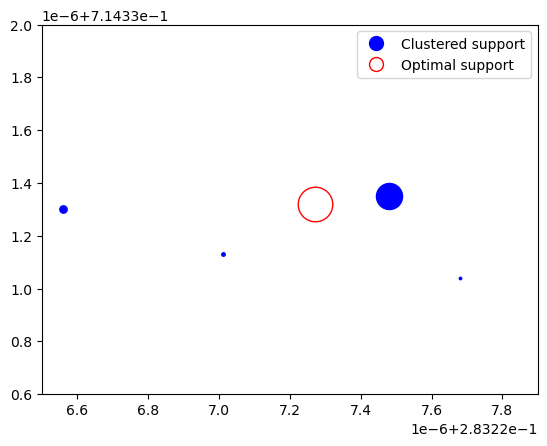

In [73]:
clustered_points = [[0.28322656, 0.7143313 ], [0.28322701, 0.71433113], [0.28322748, 0.71433135], [0.28322768, 0.71433104]]
clustered_weights = [0.21149885,  0.1,  0.75096038, 0.07]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", fillstyle="none", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", fillstyle="none", c="r", markersize=25*true_weight);
plt.ylim(7.143313e-1-7e-7, 7.143313e-1+7e-7)
plt.xlim(2.832272e-1-7e-7, 2.832272e-1+7e-7)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f14ac5309d0>


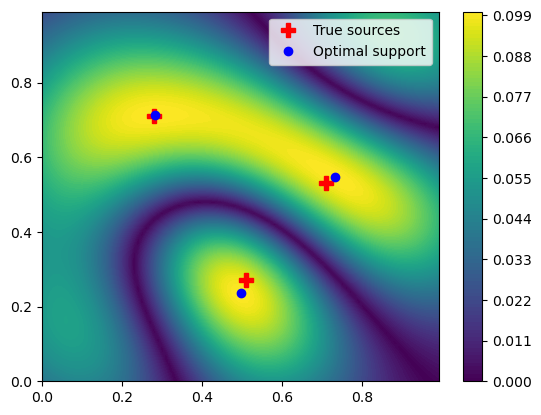

In [108]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_pdap = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698663e-02, 4.28609944e-02, 2.43456506e-02, 2.24655450e-02,
       2.19692477e-02, 1.97512431e-02, 1.45352926e-02, 1.17524225e-02,
       8.37236219e-03, 8.03803924e-03, 7.27480805e-03, 5.49766940e-03,
       4.74499601e-03, 4.33283626e-03, 3.06984423e-03, 3.03428444e-03,
       2.57014217e-03, 2.25412097e-03, 2.23311015e-03, 1.77761534e-03,
       1.74648392e-03, 1.02712747e-03, 1.00858178e-03, 7.05155587e-04,
       4.57693388e-04, 3.73211977e-04, 3.33190169e-04, 3.26992818e-04,
       3.19892471e-04, 2.76244554e-04, 2.23205519e-04, 2.02456251e-04,
       1.54179999e-04, 1.15910020e-04, 8.64004635e-05, 6.07039715e-05,
       5.67239423e-05, 4.57612933e-05, 4.45947156e-05, 4.10278346e-05,
       3.04747041e-05, 1.81648547e-05, 1.30623802e-05, 1.09291962e-05,
       1.01616338e-05, 9.32082142e-06, 8.04376061e-06, 5.27265804e-06,
       4.24350107e-06, 3.14343763e-06, 2.27059930e-06, 2.09985738e-06,
       1.54896073e-06, 1.32282125e-06, 1.21863744e-06, 7.01233291e-07,
       5.11486213e-07, 4.95514209e-07, 2.81617283e-07, 2.65567772e-07,
       2.43879425e-07, 2.04779400e-07, 1.51890929e-07, 1.42716880e-07,
       1.19812768e-07, 1.02445860e-07, 8.55149948e-08, 6.41045845e-08,
       4.00090297e-08, 2.96556866e-08, 2.79020514e-08, 2.69369677e-08,
       1.81602914e-08, 1.71166687e-08, 1.21881429e-08, 1.17864418e-08,
       1.04790152e-08, 9.05217001e-09, 4.49363399e-09, 3.01657610e-09,
       2.25290089e-09, 2.06415984e-09, 1.99861044e-09, 1.73256401e-09,
       1.58690397e-09, 1.27681066e-09, 7.37284039e-10, 6.21192930e-10,
       4.89527224e-10, 4.03469952e-10, 3.88580834e-10, 3.23770066e-10,
       2.21344443e-10, 1.92941468e-10, 1.74567971e-10, 1.35846112e-10,
       1.18579840e-10, 1.17384130e-10, 1.12501536e-10, 7.33523242e-11,
       5.95699601e-11, 4.00990630e-11, 2.89484825e-11, 2.78619905e-11,
       2.63095379e-11, 2.39352704e-11, 1.88708216e-11, 1.02573783e-11,
       3.57003316e-12, 3.34451911e-12, 2.91833224e-12, 2.88571944e-12,
       1.97855621e-12, 1.42741374e-12, 1.16195942e-12, 1.14599996e-12,
       9.89985871e-13, 8.88233931e-13, 8.23174862e-13, 7.93393129e-13,
       7.37215844e-13, 4.39509540e-13, 4.05314671e-13, 2.72865064e-13,
       2.56128452e-13, 2.25180985e-13, 2.16937579e-13, 1.61953784e-13,
       1.40804035e-13, 1.12160281e-13, 7.33857419e-14, 6.96942504e-14,
       5.86197757e-14, 4.24382751e-14, 3.43891582e-14, 3.00037772e-14,
       2.40640841e-14, 1.97064587e-14, 1.93456362e-14, 1.50990331e-14,
       1.02973186e-14, 5.85642645e-15])

times_pdap = np.array([2.38418579e-07, 4.74913359e-01, 9.37868595e-01, 1.38820481e+00,
       1.86310196e+00, 2.42706275e+00, 2.89827061e+00, 3.35857606e+00,
       3.80190110e+00, 4.26243949e+00, 4.74094105e+00, 5.24573326e+00,
       5.74106383e+00, 6.22217035e+00, 6.68332148e+00, 7.18561316e+00,
       7.65697718e+00, 8.10074544e+00, 8.54902196e+00, 9.01879621e+00,
       9.47724795e+00, 9.94312000e+00, 1.04049623e+01, 1.09362140e+01,
       1.13948026e+01, 1.18868179e+01, 1.23794615e+01, 1.28269615e+01,
       1.32999799e+01, 1.37942812e+01, 1.42404165e+01, 1.46965971e+01,
       1.51449800e+01, 1.56046414e+01, 1.61094346e+01, 1.65599830e+01,
       1.70004587e+01, 1.74523001e+01, 1.79688554e+01, 1.84535646e+01,
       1.89520309e+01, 1.94039152e+01, 1.98464453e+01, 2.03118050e+01,
       2.07464178e+01, 2.12279112e+01, 2.16971695e+01, 2.21616013e+01,
       2.26089773e+01, 2.30672331e+01, 2.35311906e+01, 2.39961829e+01,
       2.44528053e+01, 2.48939598e+01, 2.53630111e+01, 2.59189491e+01,
       2.63645225e+01, 2.68132248e+01, 2.72654107e+01, 2.77845771e+01,
       2.82574389e+01, 2.87192848e+01, 2.91615543e+01, 2.96994941e+01,
       3.01862817e+01, 3.06495149e+01, 3.11118159e+01, 3.15852985e+01,
       3.20493295e+01, 3.25958793e+01, 3.30462093e+01, 3.34922261e+01,
       3.39715934e+01, 3.46391540e+01, 3.51792524e+01, 3.57358012e+01,
       3.61861184e+01, 3.66519117e+01, 3.70935233e+01, 3.76598618e+01,
       3.81315589e+01, 3.86000986e+01, 3.90599506e+01, 3.95033894e+01,
       3.99697645e+01, 4.04590149e+01, 4.09166522e+01, 4.13951747e+01,
       4.18547478e+01, 4.22869928e+01, 4.27919233e+01, 4.32601886e+01,
       4.37075572e+01, 4.41889670e+01, 4.47355170e+01, 4.52571242e+01,
       4.57452304e+01, 4.62415364e+01, 4.67637587e+01, 4.73088443e+01,
       4.77820559e+01, 4.82794592e+01, 4.88983688e+01, 4.94323485e+01,
       4.99402382e+01, 5.04372406e+01, 5.09319575e+01, 5.14617295e+01,
       5.20156789e+01, 5.25043135e+01, 5.29999599e+01, 5.34677279e+01,
       5.39533424e+01, 5.44707923e+01, 5.49587929e+01, 5.54316669e+01,
       5.58919983e+01, 5.63565600e+01, 5.68843217e+01, 5.74423630e+01,
       5.79397662e+01, 5.84529121e+01, 5.89400091e+01, 5.94179254e+01,
       5.98929334e+01, 6.03904512e+01, 6.08812153e+01, 6.15081844e+01,
       6.20076940e+01, 6.25061731e+01, 6.30855117e+01, 6.36416700e+01,
       6.41703348e+01, 6.47529194e+01, 6.53533654e+01, 6.58231084e+01,
       6.63269973e+01, 6.68484697e+01, 6.73376892e+01, 6.78626394e+01,
       6.83684549e+01, 6.88799360e+01, 6.93615820e+01, 6.98662450e+01,
       7.03189809e+01, 7.07878931e+01, 7.13188040e+01, 7.18046191e+01,
       7.22711813e+01, 7.28430910e+01])

supports_pdap = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9])

residuals_newton = np.array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 5.05470051e+00,
       4.89062393e+00, 4.89010891e+00, 4.89010890e+00, 4.34012717e+00,
       2.57954034e+00, 2.46278057e+00, 2.45311211e+00, 2.45047563e+00,
       2.45038433e+00, 1.37210241e+00, 1.26939892e+00, 2.25970925e-01,
       2.12218494e-01, 9.46248236e-02, 9.35884195e-02, 3.21552724e-02,
       1.00042671e-02, 2.53237027e-03, 2.53085958e-03, 2.37351925e-03,
       2.37328899e-03, 2.28676260e-03, 2.28671548e-03, 1.03192011e-03,
       1.03188828e-03, 7.17546127e-05, 6.79385657e-03, 6.70808351e-05,
       7.01373085e-03, 2.91460001e-05, 7.08502512e-08, 2.90654048e-09,
       2.90654109e-09, 5.55111512e-17, 5.55111512e-17])

times_newton = np.array([9.53674316e-07, 1.17721558e-02, 4.49116230e-02, 7.59539604e-02,
       9.36255455e-02, 1.05134249e-01, 1.18456841e-01, 1.29990339e-01,
       1.40301704e-01, 1.47942543e-01, 1.53400421e-01, 1.65598631e-01,
       1.72459602e-01, 1.84104443e-01, 1.95083380e-01, 2.08044052e-01,
       2.16057539e-01, 2.30880976e-01, 2.39700079e-01, 2.46901751e-01,
       2.52110481e-01, 7.26537228e-01, 7.34773159e-01, 1.18132782e+00,
       1.19260550e+00, 1.64315152e+00, 1.65590668e+00, 1.67209411e+00,
       1.68405318e+00, 2.18301296e+00, 2.19048429e+00, 2.66101694e+00,
       2.66912293e+00, 2.67851400e+00, 2.68426681e+00, 3.17636514e+00,
       3.27437043e+00, 3.28185892e+00, 3.77028608e+00])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5, 5, 6, 6, 6, 5,
       6, 6, 7, 7, 8, 6, 7, 6, 4, 7, 4, 4, 4, 3, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  5.5],
       [ 6.5, 12.5],
       [13.5, 14.5],
       [15.5, 16.5],
       [17.5, 20.5],
       [21.5, 22.5],
       [23.5, 24.5],
       [25.5, 26.5],
       [27.5, 28.5],
       [29.5, 30.5],
       [31.5, 34.5],
       [35.5, 37.5]])

epsilons_newton = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 8.02710413e-03, 8.02710413e-03, 3.15037120e-03,
       3.15037120e-03, 1.42971551e-03, 1.42971551e-03, 1.42971551e-03,
       1.42971551e-03, 3.00910132e-04, 3.13886292e-04, 7.89920860e-05,
       9.24017034e-05, 9.24017034e-05, 9.24017034e-05, 4.64186386e-07,
       4.64186386e-07, 4.64186386e-07, 2.38762057e-16])

residuals_newton_damped = np.array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 1.59556125e+01,
       1.46006495e+01, 1.33776930e+01, 1.22753761e+01, 1.12845081e+01,
       1.03968791e+01, 9.60485702e+00, 8.90122927e+00, 8.27913165e+00,
       7.73201400e+00, 7.25362160e+00, 6.83798438e+00, 6.47940999e+00,
       6.17247893e+00, 5.91204096e+00, 5.69321212e+00, 5.51137241e+00,
       5.36216392e+00, 5.24148950e+00, 5.14551215e+00, 5.07065532e+00,
       5.01360428e+00, 4.97130886e+00, 4.94098782e+00, 4.92013480e+00,
       4.90652602e+00, 4.89822905e+00, 4.89361191e+00, 4.89135099e+00,
       4.89043497e+00, 4.89016059e+00, 4.89011206e+00, 4.89010893e+00,
       3.13259275e+00, 2.73039295e+00, 2.11989567e+00, 1.72060471e+00,
       1.40539010e+00, 1.14583499e+00, 9.29851543e-01, 7.49695470e-01,
       5.99717572e-01, 4.75444893e-01, 3.73142908e-01, 2.89592405e-01,
       2.21969734e-01, 1.67779467e-01, 1.24815174e-01, 9.11363231e-02,
       6.50549364e-02, 4.51275036e-02, 3.01473182e-02, 1.91309838e-02,
       1.12922891e-02, 5.99940138e-03, 2.71838994e-03, 9.55220665e-04,
       2.16622416e-04, 1.68619127e-05, 1.68609332e-05, 1.64040502e-05,
       1.64040560e-05, 3.31479508e-07, 4.51515376e-03, 2.59542089e-03,
       1.38103304e-03, 6.62858940e-04, 2.75846533e-04, 9.32742530e-05,
       2.28242669e-05, 3.21104956e-06, 1.54953146e-07, 7.32979899e-10,
       2.14273044e-14, 2.77555756e-17, 2.77555756e-17])

times_newton_damped = np.array([9.53674316e-07, 1.30629539e-02, 3.85491848e-02, 6.79314137e-02,
       8.64751339e-02, 9.85915661e-02, 1.12589359e-01, 1.18569613e-01,
       1.25141144e-01, 1.32115841e-01, 1.38110876e-01, 1.48327827e-01,
       1.54115200e-01, 1.60012007e-01, 1.65619135e-01, 1.71226740e-01,
       1.81638718e-01, 1.87202215e-01, 1.92750931e-01, 1.98544025e-01,
       2.04016209e-01, 2.13208914e-01, 2.19324589e-01, 2.25996733e-01,
       2.30541229e-01, 2.35401630e-01, 2.45491743e-01, 2.50427961e-01,
       2.57094622e-01, 2.64638901e-01, 2.71893024e-01, 2.81980991e-01,
       2.87935019e-01, 2.93975592e-01, 2.99725056e-01, 3.05272818e-01,
       3.18949461e-01, 3.30574274e-01, 3.40374231e-01, 3.48466873e-01,
       3.54861021e-01, 3.68287563e-01, 3.74646902e-01, 3.80773306e-01,
       3.87091637e-01, 3.94129992e-01, 4.08883810e-01, 4.16258812e-01,
       4.22983170e-01, 4.29620981e-01, 4.36131716e-01, 4.50032473e-01,
       4.56806898e-01, 4.63699579e-01, 4.70091820e-01, 4.76415873e-01,
       4.89395857e-01, 4.95902061e-01, 5.02147198e-01, 5.08528233e-01,
       5.14651537e-01, 1.11896920e+00, 1.12680531e+00, 1.58522820e+00,
       1.59376669e+00, 2.05539942e+00, 2.06494570e+00, 2.07180429e+00,
       2.07775497e+00, 2.08368444e+00, 2.09584618e+00, 2.10085464e+00,
       2.10545850e+00, 2.11236835e+00, 2.11736870e+00, 2.12826109e+00,
       2.13381314e+00, 2.13861179e+00, 2.60694933e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5, 35.5],
       [36.5, 60.5],
       [61.5, 62.5],
       [63.5, 64.5],
       [65.5, 77.5]])

epsilons_newton_damped = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 2.06217567e-04, 2.06217567e-04, 4.89223967e-05,
       4.89223968e-05, 1.82190769e-06, 1.05371932e-05, 1.05371932e-05,
       1.05371932e-05, 1.05371932e-05, 1.05371932e-05, 1.05371932e-05,
       1.05371932e-05, 1.05371932e-05, 1.05371932e-05, 1.05371932e-05,
       1.05371932e-05, 1.05371932e-05, 7.35575397e-16])

residuals_lpdap = np.array([2.56626430e+01, 5.68389440e+00, 2.59001762e+00, 1.71526034e+00,
       2.30637898e-01, 1.22566758e-01, 5.96825853e-02, 5.71032551e-02,
       5.37492391e-02, 4.16045844e-02, 2.03598267e-02, 1.93706673e-02,
       1.85833768e-02, 1.51983338e-02, 1.22265689e-02, 1.00988540e-02,
       9.18285653e-03, 9.16159304e-03, 6.74778952e-03, 6.63693550e-03,
       5.00805471e-03, 4.13419770e-03, 3.17574276e-03, 3.11052398e-03,
       2.07517615e-03, 2.01844006e-03, 1.90071789e-03, 1.53662902e-03,
       1.50583899e-03, 1.41899623e-03, 1.21664114e-03, 7.14839457e-04,
       4.81816060e-04, 4.62702814e-04, 4.23694841e-04, 4.04078290e-04,
       2.17976615e-04, 1.97178927e-04, 9.34997318e-05, 9.13325724e-05,
       8.04182656e-05, 7.15126613e-05, 5.17776089e-05, 5.04005325e-05,
       4.09368380e-05, 3.68240540e-05, 3.62418886e-05, 3.33097242e-05,
       2.43554665e-05, 1.79886788e-05, 1.04209825e-05, 1.01928712e-05,
       9.53415448e-06, 4.12637450e-06, 3.93839243e-06, 3.76058678e-06,
       2.94205604e-06, 2.87562365e-06, 2.64616615e-06, 1.86607857e-06,
       1.58147434e-06, 1.53350167e-06, 1.46365046e-06, 1.15108725e-06,
       1.11460876e-06, 1.05694259e-06, 9.19355263e-07, 8.07222794e-07,
       3.90365228e-07, 3.73766897e-07, 3.64643273e-07, 3.10757960e-07,
       2.43168418e-07, 1.99745936e-07, 1.93785527e-07, 1.37470684e-07,
       1.01171889e-07, 9.95314802e-08, 9.76414808e-08, 6.97171764e-08,
       6.42417226e-08, 6.31816674e-08, 2.03199655e-08, 1.75525472e-08,
       1.45908988e-08, 1.32740738e-08, 7.01584946e-09, 5.30282213e-09,
       3.60260485e-09, 3.40989906e-09, 1.39218431e-09, 1.27260730e-09,
       1.27124983e-09, 6.66197653e-10, 2.86586727e-10, 2.85503537e-10,
       2.76889067e-10, 2.29266384e-10, 1.79873560e-10, 1.32051370e-10,
       1.27023420e-10, 7.89422694e-11, 3.45855566e-11, 2.89073487e-11,
       2.79146983e-11, 2.79146706e-11, 1.20174704e-11, 1.20174704e-11,
       1.08491549e-11, 7.43624606e-12, 6.67574329e-12, 6.47504272e-12,
       3.39878126e-12, 3.34071659e-12, 3.17465498e-12, 2.80045431e-12,
       2.80042656e-12, 2.80042656e-12, 8.41965386e-13, 7.34967642e-13,
       7.34967642e-13, 3.47222251e-13, 1.97952765e-13, 1.17628129e-13,
       6.73350264e-14, 6.19504448e-14, 4.92939023e-14, 4.83502127e-14,
       4.83779683e-14, 4.83779683e-14, 1.54876112e-14, 1.45716772e-14,
       1.26287869e-14, 1.25455202e-14])

times_lpdap = np.array([2.40302086e-03, 1.88283920e-02, 3.88708115e-02, 5.76183796e-02,
       7.80675411e-02, 9.49513912e-02, 1.15957737e-01, 1.36925936e-01,
       1.58361912e-01, 6.45673275e-01, 6.63035870e-01, 6.85289145e-01,
       7.08512068e-01, 1.22037530e+00, 1.24313927e+00, 1.74116111e+00,
       1.76044488e+00, 1.77871346e+00, 1.80336809e+00, 1.82597589e+00,
       1.84586215e+00, 2.38425851e+00, 2.40752268e+00, 2.42904711e+00,
       2.92453718e+00, 2.94203115e+00, 2.95965576e+00, 2.98498774e+00,
       3.00237584e+00, 3.01917100e+00, 3.03608370e+00, 3.05406857e+00,
       3.07280445e+00, 3.56501865e+00, 3.58139491e+00, 3.59456801e+00,
       4.08242130e+00, 4.09912062e+00, 4.11471128e+00, 4.62777257e+00,
       4.63871217e+00, 4.65029430e+00, 4.66227198e+00, 4.67285228e+00,
       5.15573049e+00, 5.16566777e+00, 5.17796779e+00, 5.19075727e+00,
       5.20406032e+00, 5.78946280e+00, 5.80416107e+00, 5.81557965e+00,
       5.82688355e+00, 6.30392408e+00, 6.31600451e+00, 6.32707977e+00,
       6.83070660e+00, 6.84115553e+00, 6.84973598e+00, 6.86289930e+00,
       6.87563801e+00, 6.88797140e+00, 7.40313673e+00, 7.87834144e+00,
       7.88821340e+00, 7.89652348e+00, 7.90791774e+00, 8.43594456e+00,
       8.44792652e+00, 8.45964313e+00, 8.96171451e+00, 8.97071910e+00,
       9.44655061e+00, 9.45851946e+00, 9.46756530e+00, 9.47842908e+00,
       9.48879957e+00, 9.98939347e+00, 9.99817371e+00, 1.00080266e+01,
       1.00184395e+01, 1.00284507e+01, 1.05068140e+01, 1.05184920e+01,
       1.10030899e+01, 1.10139070e+01, 1.15764377e+01, 1.21140480e+01,
       1.21283135e+01, 1.26396096e+01, 1.31500316e+01, 1.36682684e+01,
       1.41238573e+01, 1.41378846e+01, 1.45922544e+01, 1.50325494e+01,
       1.50414147e+01, 1.50494704e+01, 1.55178494e+01, 1.55331588e+01,
       1.55438228e+01, 1.55575094e+01, 1.60823793e+01, 1.65421231e+01,
       1.70605783e+01, 1.75106094e+01, 1.75302644e+01, 1.80010109e+01,
       1.80139358e+01, 1.84719102e+01, 1.84859476e+01, 1.84968176e+01,
       1.89750936e+01, 1.89829628e+01, 1.89883385e+01, 1.89997082e+01,
       1.94923437e+01, 1.99868438e+01, 2.00076694e+01, 2.06872489e+01,
       2.06971254e+01, 2.07220764e+01, 2.13750060e+01, 2.13894169e+01,
       2.14081635e+01, 2.14317129e+01, 2.21176069e+01, 2.26475723e+01,
       2.26585197e+01, 2.26656508e+01, 2.32618828e+01, 2.37441654e+01,
       2.37550089e+01, 2.42122476e+01])

supports_lpdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  7,  7,  8,  9,  8,  8,  8,  9,
       10,  9, 10,  9,  9,  8,  8,  8,  8,  8,  7,  8,  8,  8,  7,  6,  7,
        7,  8,  8,  8,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  8,  8,
        8,  9,  8,  9,  8,  8,  9,  8,  8,  8,  9, 10,  8,  9,  9,  9,  8,
        8,  8,  9,  8,  9,  9, 10,  8,  8,  9, 12,  9,  9,  9,  9, 11,  9,
        9, 10,  9,  9, 12, 10,  8,  8,  8,  9,  9, 10, 10,  9,  8,  8,  9,
        9,  8,  9, 12,  8, 11,  9,  9,  8,  8,  8,  9,  9,  9, 12, 12,  9,
        9,  9,  8,  9, 11,  9,  8,  9,  9,  9,  9,  7,  9, 11, 14])

epsilons_lpdap = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 2.28377259e-02, 2.28377259e-02,
       2.28377259e-02, 2.28377259e-02, 1.10086077e-02, 1.10086077e-02,
       4.76055765e-03, 4.76055765e-03, 4.76055765e-03, 4.76055765e-03,
       4.76055765e-03, 4.76055765e-03, 1.75057689e-03, 1.75057689e-03,
       1.75057689e-03, 6.95182438e-04, 6.95182438e-04, 6.95182438e-04,
       6.95182438e-04, 6.95182438e-04, 6.95182438e-04, 6.95182438e-04,
       6.95182438e-04, 6.95182438e-04, 2.53512255e-04, 2.53512255e-04,
       2.53512255e-04, 1.10008501e-04, 1.10008501e-04, 1.10008501e-04,
       3.75350673e-05, 3.75350673e-05, 3.75350673e-05, 3.75350673e-05,
       3.75350673e-05, 1.61225574e-05, 1.61225574e-05, 1.61225574e-05,
       1.61225574e-05, 1.61225574e-05, 6.09850467e-06, 6.09850467e-06,
       6.09850467e-06, 6.09850467e-06, 2.59784031e-06, 2.59784031e-06,
       2.59784031e-06, 1.15572894e-06, 1.15572894e-06, 1.15572894e-06,
       1.15572894e-06, 1.15572894e-06, 1.15572894e-06, 1.15572894e-06,
       5.69068314e-07, 5.69068314e-07, 5.69068314e-07, 5.69068314e-07,
       2.84128204e-07, 2.84128204e-07, 2.84128204e-07, 2.84128204e-07,
       2.84128204e-07, 8.14205644e-08, 8.14205644e-08, 8.14205644e-08,
       8.14205644e-08, 8.14205644e-08, 3.59096676e-08, 3.59096676e-08,
       3.59096676e-08, 3.59096676e-08, 3.59096676e-08, 1.06498169e-08,
       1.06498169e-08, 1.06498169e-08, 1.06498169e-08, 1.06498169e-08,
       2.46689882e-09, 2.46689882e-09, 2.46689882e-09, 2.46689882e-09,
       2.46689882e-09, 4.01072822e-10, 4.01072822e-10, 4.01072822e-10,
       1.18378282e-10, 1.18378282e-10, 1.18378282e-10, 5.50393111e-11,
       5.50393111e-11, 5.50393111e-11, 5.50393111e-11, 5.50393111e-11,
       5.50393111e-11, 1.36782484e-11, 1.36782484e-11, 1.36782484e-11,
       1.36782484e-11, 1.36782484e-11, 3.21690641e-12, 3.21690641e-12,
       3.21690641e-12, 1.11115670e-12, 1.11115670e-12, 1.11115670e-12,
       1.11115670e-12, 1.11115670e-12, 1.11115670e-12, 1.11115670e-12,
       3.34635951e-13, 3.34635951e-13, 3.34635951e-13, 8.27855866e-14,
       8.27855866e-14, 8.27855866e-14, 8.27855866e-14, 8.27855866e-14,
       2.37726768e-14, 2.37726768e-14, 2.37726768e-14, 1.08373472e-14,
       2.63490350e-15, 2.63490350e-15])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-14, 30);
# plt.xlim(0, 135);
plt.legend();
plt.show()

In [ ]:
names = ["LPDAP", "Newton", "Newton (damped)"]
styles = ["--", "-.", ":"]
colors = ["orange", "green", "red"]
plt.figure(figsize=(11.25,5))
for array, name, style, color in zip([epsilons_lpdap, epsilons_newton, epsilons_newton_damped], names, styles, colors):
    plt.semilogy(np.array(range(len(array))),array, style, label=name, color=color);
plt.ylabel("Lazy threshold");
plt.xlabel("Total iterations");
plt.ylim(1e-14, 0.1);
# plt.xlim(0, 135);
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-14, 30);
# plt.xlim(0, 60);
plt.legend();
plt.show()

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton, linestyle="-.", color="green");
for interval in intervals_newton:
    plt.fill_between(interval, 0, 30, hatch="/", color="gray", alpha=0.2);
plt.ylim(1e-14, 30);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.show()

# Signal Processing

## Generate Data and Define Functions

In [19]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [20]:
observations = np.arange(0,1,1/observation_resolution)

In [21]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [22]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [23]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [24]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [25]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [26]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [27]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [28]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [29]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [30]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [31]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(kappa(a), axis=1)
norm_kappa = max(vals)
norm_kappa

8.436705235037092

In [32]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(grad_kappa(a), axis=(1,2))
norm_kappa1 = max(norm_kappa, max(vals))
norm_kappa1

39.48990157632303

In [33]:
gamma = 1
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-1
L_H

1.0

## Experiments

In [34]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           norm_kappa1=norm_kappa1,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R,
           M=50
           )

### PDAP

In [60]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-13)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: Phi:2.102E+03, support: [[3.13588856]], coefs: [-1.02219696], x: [7.00005078]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:2: Phi:1.497E+03, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], x: [13.38203765]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:3: Phi:9.018E+01, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], x: [2.81555416]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:4: Phi:3.918E+01, support: [[ 2.81555416]
 [ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.03816109 -0.97952737  0.69852898  0.49805815

In [61]:
best = objective_values[-1]
best

0.2197538626001281

In [62]:
np.array(times[:70])

array([7.15255737e-07, 7.10942745e-02, 1.37944221e-01, 2.02565193e-01,
       2.63253689e-01, 3.25871944e-01, 3.89717817e-01, 4.57018614e-01,
       5.18006563e-01, 5.82626104e-01, 6.45598173e-01, 7.10513830e-01,
       7.82218695e-01, 8.46473217e-01, 9.12332058e-01, 9.78180170e-01,
       1.04240346e+00, 1.10355473e+00, 1.19117808e+00, 1.27486348e+00,
       1.36316347e+00, 1.45105171e+00, 1.53759813e+00, 1.62582803e+00,
       1.71229649e+00, 1.79830003e+00, 1.87463450e+00, 1.95181584e+00,
       2.02015448e+00, 2.11013031e+00, 2.17733741e+00, 2.24303889e+00,
       2.30702353e+00, 2.37057710e+00, 2.43452668e+00, 2.51385498e+00,
       2.60160160e+00, 2.69018650e+00, 2.77254057e+00, 2.87004519e+00,
       2.95777178e+00, 3.04831219e+00, 3.13861179e+00, 3.20839477e+00,
       3.27236319e+00, 3.33682895e+00, 3.40034842e+00, 3.46725273e+00,
       3.53138566e+00, 3.59732604e+00, 3.66723180e+00, 3.75577211e+00,
       3.84494805e+00, 3.93447018e+00, 4.02343917e+00, 4.11328435e+00,
      

In [63]:
np.array(supports[:70])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6])

In [64]:
objective_values[:70]-best

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239775e-02, 8.58376252e-03, 6.60215205e-03, 6.26160457e-03,
       5.81056957e-03, 5.68714554e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625307e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583831e-04, 3.70010641e-04, 3.28227689e-04, 3.27716481e-04,
       1.08225418e-04, 8.89059417e-05, 8.85996713e-05, 2.08581055e-05,
       1.15859896e-05, 1.14112380e-05, 8.58446562e-06, 4.06824488e-06,
       3.96465445e-06, 2.55842288e-06, 1.39500359e-06, 1.33895639e-06,
       6.37729845e-07, 3.72191365e-07, 3.43278988e-07, 1.86417488e-07,
       1.07770631e-07, 9.30291451e-08, 4.47906126e-08, 3.13019586e-08,
       2.38731729e-08, 1.63321581e-08, 9.87044438e-09, 6.13792947e-09,
       2.36218306e-09, 2.29294589e-09, 4.22666513e-10, 3.32070621e-10,
       2.96450947e-10, 1.96910321e-10, 1.51273355e-10, 1.33152378e-10,
       8.30928937e-11, 6.01859673e-11, 5.10477494e-11, 2.59457178e-11,
      

In [65]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502169]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502184]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999264]
 [13.37905646]
 [13.37905646]
 [13.37905646]
 [13.37905647]
 [13.37905647]
 [13.37905647]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905653]
 [13.37905653]
 [13.3790566 ]] and coefficients [-6.89131579e-01 -1.17955969e-02 -1.40167925e-02 -9.89651048e-03
 -1.85719056e-02 -1.25798711e-02 -1.07661405e-03 -2.03044158e-02
 -1.07376356e-02 -2.29676144e-02 -1.87248742e-01  1.35305736e-02
  5.86089397e-02  5.31554647e-02  3.41449537e-02  7.37017986e-03
  8.27745783e-03  7.20393971e-03  1.98668374e-02  3.37583560e-03
  1.00067894e-02  1.46007272e-02  1.71288548e-02  1

### Newton

In [66]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=False)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.5291269403006611, objective: 5.291E+01, dropped:False
INFO:root:2, 1: lazy: True, support: [[3.10517529]], coefs: [-0.20775711], epsilon: 0.5291269403006611, objective: 4.188E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[3.27164622]], coefs: [-1.08547986], epsilon: 0.5291269403006611, objective: 3.112E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[3.05511777]], coefs: [-1.30703184], epsilon: 0.5291269403006611, objective: 2.871E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[3.12602412]], coefs: [-1.06623658], epsilon: 0.5291269403006611, objective: 2.260E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[3.13547144]], coefs: [-1.02299012], epsilon: 0.5291269403006611, objective: 2.250E+01
INFO:root:True, True, True, True, True
INFO:root:2, 6: lazy: N/A, support: [[3.13591136]], coefs: [-1.022198

In [67]:
dropped_tot

1

In [68]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.09029774e+01,
        2.84925698e+01,  2.23790151e+01,  2.22758082e+01,  2.22757012e+01,
        7.51520858e+00,  4.77281182e+00,  3.55951070e+00,  7.72924321e-02,
        3.75464937e-01,  7.18795911e-03,  2.59752249e-03,  1.44729600e+01,
        1.40443125e-03,  1.35205204e-03,  1.82277977e-04,  8.01635083e-04,
        7.62753150e-09, -4.41313652e-15, -4.41313652e-15])

In [69]:
np.array(times)

array([4.76837158e-07, 6.50596619e-03, 1.98342800e-02, 5.68568707e-02,
       7.21573830e-02, 8.43966007e-02, 1.00948095e-01, 1.15883827e-01,
       1.31341219e-01, 1.44586325e-01, 1.60718679e-01, 1.74558401e-01,
       1.87510252e-01, 2.04228163e-01, 2.89637089e-01, 2.99510241e-01,
       3.19288731e-01, 3.49055767e-01, 4.45847034e-01, 4.58795071e-01,
       4.74615335e-01, 4.83373165e-01, 6.60640717e-01])

In [70]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 3, 3, 3,
       3])

In [71]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5,  7.5],
       [ 8.5, 10.5],
       [11.5, 13.5],
       [14.5, 15.5],
       [16.5, 17.5],
       [18.5, 21.5]])

In [72]:
np.array(epsilons)

array([5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.32207961e-01, 5.32207961e-01, 1.15745643e-01, 2.60450952e-01,
       1.15745643e-01, 1.15745643e-01, 3.67951758e-03, 3.68571286e-03,
       3.68571286e-03, 3.68571286e-03, 1.03306252e-15])

In [73]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

7
7
4
7


In [77]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[3.74700271e-15]
4.773959005888173e-15


In [78]:
print(np.linalg.norm(np.array([x[0] for x in u.support]) - np.array([x[0] for x in true_sources])))
print(np.linalg.norm(u.coefficients-true_weights))

3.911190177122026e-05
0.0028429187726321443


In [79]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([841.50400003, 377.40347866, 187.63319262,  56.17717494,
        61.42436526,  60.16886452])

### Newton Damped

In [88]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=True, damping_root=1)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.5291269403006611, objective: 5.291E+01, dropped:False
INFO:root:2, 1: lazy: True, support: [[3.10517529]], coefs: [-0.20775711], epsilon: 0.5291269403006611, objective: 4.188E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[3.11351583]], coefs: [-0.25173285], epsilon: 0.5291269403006611, objective: 3.983E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[3.11847898]], coefs: [-0.2926916], epsilon: 0.5291269403006611, objective: 3.802E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[3.12184754]], coefs: [-0.33188294], epsilon: 0.5291269403006611, objective: 3.639E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[3.12429631]], coefs: [-0.36968854], epsilon: 0.5291269403006611, objective: 3.491E+01
INFO:root:True, True, True, True, True
INFO:root:2, 6: lazy: N/A, support: [[3.12615761]], coefs: [-0.4062647

In [75]:
dropped_tot

0

In [76]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.96065862e+01,
        3.78034581e+01,  3.61744035e+01,  3.46903068e+01,  3.33352483e+01,
        3.20982247e+01,  3.09704677e+01,  2.99443907e+01,  2.90131204e+01,
        2.81702685e+01,  2.74098124e+01,  2.67260291e+01,  2.61134569e+01,
        2.55668730e+01,  2.50812785e+01,  2.46518900e+01,  2.42741327e+01,
        2.39436371e+01,  2.36562353e+01,  2.34079599e+01,  2.31950415e+01,
        2.30139082e+01,  2.28611842e+01,  2.27336895e+01,  2.26284386e+01,
        2.25426402e+01,  2.24736967e+01,  2.24192029e+01,  2.23769461e+01,
        2.23449045e+01,  2.23212469e+01,  2.23043313e+01,  2.22927039e+01,
        2.22850971e+01,  2.22804279e+01,  2.22777952e+01,  2.22764757e+01,
        2.22759193e+01,  2.22757404e+01,  7.51965812e+00,  4.77697568e+00,
        4.05889828e+00,  3.48568204e+00,  2.98872994e+00,  2.55188018e+00,
        2.16708748e+00,  1.82880914e+00,  1.53255007e+00,  1.27436574e+00,
        1.05066214e+00,  

In [77]:
np.array(times)

array([2.38418579e-07, 5.52439690e-03, 2.12852955e-02, 3.82549763e-02,
       4.73887920e-02, 5.65872192e-02, 6.83155060e-02, 7.67574310e-02,
       8.70845318e-02, 9.56392288e-02, 1.05882168e-01, 1.22090340e-01,
       1.37080193e-01, 1.47738457e-01, 1.59191370e-01, 1.70231819e-01,
       1.87235355e-01, 1.98046684e-01, 2.09177732e-01, 2.19868898e-01,
       2.30691195e-01, 2.43422270e-01, 2.54567146e-01, 2.65667915e-01,
       2.82950878e-01, 2.99523592e-01, 3.18113804e-01, 3.29379082e-01,
       3.40528250e-01, 3.51556778e-01, 3.63803864e-01, 3.80884886e-01,
       3.92153025e-01, 4.01927948e-01, 4.14379597e-01, 4.25532341e-01,
       4.42381144e-01, 4.53332901e-01, 4.64960575e-01, 4.76015568e-01,
       4.87050772e-01, 5.03595591e-01, 5.18967628e-01, 5.31983137e-01,
       5.48319817e-01, 5.59706450e-01, 5.69675684e-01, 5.87658882e-01,
       5.99354982e-01, 6.11213923e-01, 6.22947931e-01, 6.34580851e-01,
       6.51666403e-01, 6.64225817e-01, 6.78016663e-01, 6.90412521e-01,
      

In [78]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [79]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5, 41.5],
       [42.5, 74.5],
       [75.5, 78.5]])

In [80]:
np.array(epsilons)

array([5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
      

In [81]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

16
17
2
4


In [87]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[2.10942375e-15]
2.8033131371785203e-15


### LPDAP

In [35]:
u, Phi_ks, times, supports, objective_values, dropped_tot, epsilons = exp.lpdap(tol=1e-12)

INFO:root:1: Step: GCG, Lazy True, Phi_k: 2.958E+03, epsilon: 5.291E-01, support: [], coefs: [], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: Step: GCG, Lazy True, Phi_k: 2.127E+03, epsilon: 5.291E-01, support: [[3.10517529]], coefs: [-1.01399371], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:3: Step: GCG, Lazy True, Phi_k: 1.471E+03, epsilon: 5.291E-01, support: [[3.10517529]
 [7.01168614]], coefs: [-0.98974115  0.71089649], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:4: Step: GCG, Lazy True, Phi_k: 1.917E+02, epsilon: 5.291E-01, support: [[ 3.10517529]
 [ 7.01168614]
 [13.42237062]], coefs: [-0.99640013  0.7057881   0.48933592], dropped:F

In [83]:
dropped_tot

1

In [84]:
np.array(times)

array([2.36678123e-03, 2.86026001e-02, 6.24766350e-02, 9.06140804e-02,
       1.18812561e-01, 1.47308350e-01, 1.72964096e-01, 1.99899197e-01,
       2.25249767e-01, 2.58099079e-01, 2.94057608e-01, 4.08305883e-01,
       4.45648193e-01, 4.82359886e-01, 5.20535469e-01, 6.12308264e-01,
       6.46299839e-01, 6.79507971e-01, 7.17610836e-01, 7.58677244e-01,
       8.78158808e-01, 9.16597843e-01, 9.54154015e-01, 9.91848230e-01,
       1.02819610e+00, 1.06353354e+00, 1.10255265e+00, 1.19905019e+00,
       1.22688866e+00, 1.27552438e+00, 1.38438010e+00, 1.41797829e+00,
       1.45015788e+00, 1.48125267e+00, 1.51072788e+00, 1.54153728e+00,
       1.56882691e+00, 1.65349650e+00, 1.67631197e+00, 1.70702100e+00,
       1.75429654e+00, 1.86094356e+00, 1.88267255e+00, 1.91093969e+00,
       2.01413536e+00, 2.03997421e+00, 2.14433575e+00, 2.25002766e+00,
       2.33184910e+00, 2.34909201e+00, 2.43661571e+00, 2.45632482e+00,
       2.47852921e+00, 2.49779367e+00, 2.51422095e+00, 2.59168434e+00,
      

In [85]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 19, 19, 19,
       19, 19, 17, 13, 13, 12, 12, 13, 10,  7,  8,  7,  6,  6,  6,  6,  6,
        7,  6,  7,  6,  6,  7,  6,  7,  6,  6,  7,  6,  7,  6,  6,  7,  6,
        7,  6,  6,  7,  6,  7,  6,  6,  7,  7,  6,  7,  7,  6,  8,  7,  6,
        6,  6,  6,  7,  7, 10,  6,  6,  6,  6,  6,  9,  7,  6,  9,  6,  6,
        6,  6,  6,  7,  6,  7,  7, 10])

In [86]:
objective_values-best

array([5.26929402e+01, 2.27036009e+01, 7.58425867e+00, 3.86667308e-01,
       2.21045186e-01, 9.90362682e-02, 7.93030173e-02, 5.97189281e-02,
       4.40736088e-02, 3.74879267e-02, 3.39454818e-02, 3.00857417e-02,
       2.80749561e-02, 2.60983521e-02, 2.54309728e-02, 2.47799302e-02,
       2.43835289e-02, 2.40045013e-02, 2.37038701e-02, 2.35280525e-02,
       2.34023454e-02, 2.33329317e-02, 2.20727787e-02, 2.18533237e-02,
       1.66786865e-02, 1.02362879e-02, 9.95975886e-03, 9.92838652e-03,
       9.89672697e-03, 9.88887821e-03, 9.88591054e-03, 8.62324992e-03,
       8.59863616e-03, 8.49170807e-03, 8.45563517e-03, 8.37657719e-03,
       5.96166299e-03, 3.25666379e-03, 3.25399616e-03, 2.61305369e-03,
       2.60580625e-03, 2.60573043e-03, 1.51773950e-03, 7.58153357e-04,
       7.58044427e-04, 5.09726761e-04, 1.65862517e-04, 1.21121759e-04,
       3.87651625e-05, 1.91000485e-05, 1.38044530e-05, 1.26394257e-05,
       1.25941871e-05, 1.11355528e-05, 9.97444524e-06, 4.72342061e-06,
      

In [87]:
np.array(epsilons)

array([5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       2.27284164e-01, 2.27284164e-01, 2.27284164e-01, 2.27284164e-01,
       1.01243248e-01, 1.01243248e-01, 1.01243248e-01, 1.01243248e-01,
       1.01243248e-01, 4.42281205e-02, 4.42281205e-02, 4.42281205e-02,
       4.42281205e-02, 4.42281205e-02, 4.42281205e-02, 4.42281205e-02,
       1.81449330e-02, 1.81449330e-02, 1.81449330e-02, 8.61361903e-03,
       8.61361903e-03, 8.61361903e-03, 8.61361903e-03, 8.61361903e-03,
       8.61361903e-03, 8.61361903e-03, 2.32347057e-03, 2.32347057e-03,
       2.32347057e-03, 2.32347057e-03, 1.09530571e-03, 1.09530571e-03,
       1.09530571e-03, 4.18730572e-04, 4.18730572e-04, 1.50531699e-04,
       6.82074241e-05, 3.21108875e-05, 3.21108875e-05, 1.32599693e-05,
       1.32599693e-05, 1.32599693e-05, 1.32599693e-05, 1.32599693e-05,
      

In [93]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502158]
 [ 3.12502183]
 [ 3.125022  ]
 [ 6.99999251]
 [ 6.99999273]
 [ 6.99999282]
 [ 6.99999297]
 [13.37905641]
 [13.37905658]
 [13.37905674]] and coefficients [-0.62175041 -0.06311628 -0.31346059  0.47376811  0.07243667  0.15082036
  0.00138777  0.34845756  0.04115659  0.10872292]
[2.50632848e-14]
2.5146551507759796e-14


## Plots

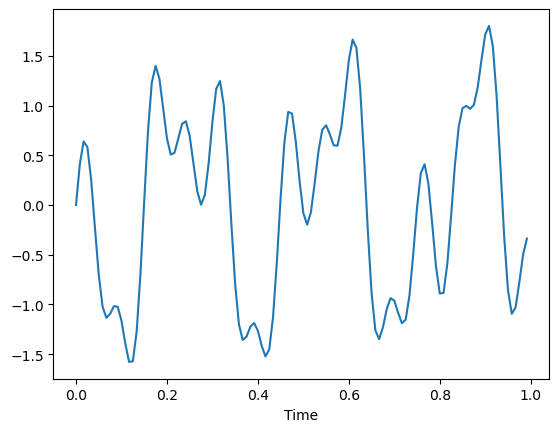

In [119]:
plt.plot(observations, target);
plt.xlabel("Time");

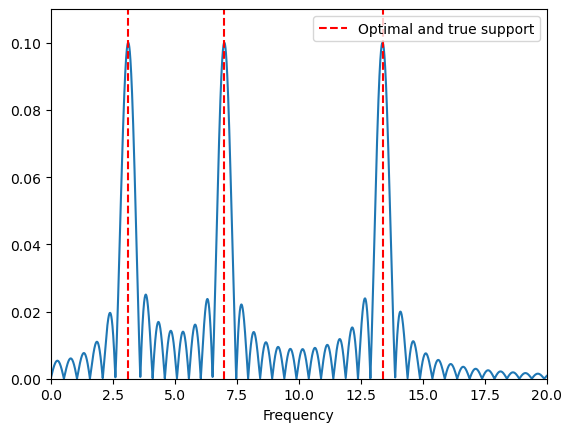

In [ ]:
u_tilde = u # Newton solution
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11);
plt.xlim(0, 20);
plt.legend();

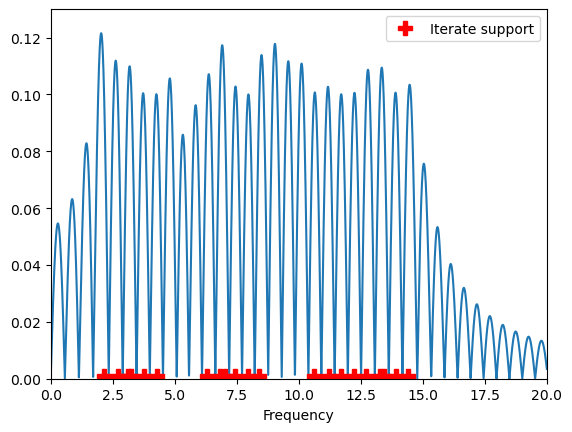

In [ ]:
u_tilde = u # LPDAP iterate after 30 ierations
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.plot(pos,0.001, "P", c="r", label="Iterate support", markersize=10)
    else:
        plt.plot(pos,0.001, "P", c="r", markersize=10)
plt.xlabel("Frequency");
plt.ylim(0,0.13);
plt.xlim(0, 20);
plt.legend();

In [ ]:
residuals_pdap = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239775e-02, 8.58376252e-03, 6.60215205e-03, 6.26160457e-03,
       5.81056957e-03, 5.68714554e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625307e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583831e-04, 3.70010641e-04, 3.28227689e-04, 3.27716481e-04,
       1.08225418e-04, 8.89059417e-05, 8.85996713e-05, 2.08581055e-05,
       1.15859896e-05, 1.14112380e-05, 8.58446562e-06, 4.06824488e-06,
       3.96465445e-06, 2.55842288e-06, 1.39500359e-06, 1.33895639e-06,
       6.37729845e-07, 3.72191365e-07, 3.43278988e-07, 1.86417488e-07,
       1.07770631e-07, 9.30291451e-08, 4.47906126e-08, 3.13019586e-08,
       2.38731729e-08, 1.63321581e-08, 9.87044438e-09, 6.13792947e-09,
       2.36218306e-09, 2.29294589e-09, 4.22666513e-10, 3.32070621e-10,
       2.96450947e-10, 1.96910321e-10, 1.51273355e-10, 1.33152378e-10,
       8.30928937e-11, 6.01859673e-11, 5.10477494e-11, 2.59457178e-11,
       1.44746715e-11, 9.88614746e-12, 6.27364827e-12, 4.28321267e-12,
       3.35237393e-12, 1.54171120e-12, 6.05404615e-13, 2.65676370e-13,
       1.60566005e-13, 1.45883305e-13, 1.14630527e-13, 6.17839113e-14,
       5.43731726e-14, 3.87467836e-14])

times_pdap = np.array([7.15255737e-07, 7.10942745e-02, 1.37944221e-01, 2.02565193e-01,
       2.63253689e-01, 3.25871944e-01, 3.89717817e-01, 4.57018614e-01,
       5.18006563e-01, 5.82626104e-01, 6.45598173e-01, 7.10513830e-01,
       7.82218695e-01, 8.46473217e-01, 9.12332058e-01, 9.78180170e-01,
       1.04240346e+00, 1.10355473e+00, 1.19117808e+00, 1.27486348e+00,
       1.36316347e+00, 1.45105171e+00, 1.53759813e+00, 1.62582803e+00,
       1.71229649e+00, 1.79830003e+00, 1.87463450e+00, 1.95181584e+00,
       2.02015448e+00, 2.11013031e+00, 2.17733741e+00, 2.24303889e+00,
       2.30702353e+00, 2.37057710e+00, 2.43452668e+00, 2.51385498e+00,
       2.60160160e+00, 2.69018650e+00, 2.77254057e+00, 2.87004519e+00,
       2.95777178e+00, 3.04831219e+00, 3.13861179e+00, 3.20839477e+00,
       3.27236319e+00, 3.33682895e+00, 3.40034842e+00, 3.46725273e+00,
       3.53138566e+00, 3.59732604e+00, 3.66723180e+00, 3.75577211e+00,
       3.84494805e+00, 3.93447018e+00, 4.02343917e+00, 4.11328435e+00,
       4.20030189e+00, 4.27832723e+00, 4.35173821e+00, 4.41759443e+00,
       4.48396587e+00, 4.56928182e+00, 4.65706325e+00, 4.73500419e+00,
       4.79931521e+00, 4.86404824e+00, 4.92714167e+00, 4.99341488e+00,
       5.05845332e+00, 5.12547612e+00])

supports_pdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6])

residuals_newton = np.array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.09029774e+01,
        2.84925698e+01,  2.23790151e+01,  2.22758082e+01,  2.22757012e+01,
        7.51520858e+00,  4.77281182e+00,  3.55951070e+00,  7.72924321e-02,
        3.75464937e-01,  7.18795911e-03,  2.59752249e-03,  1.44729600e+01,
        1.40443125e-03,  1.35205204e-03,  1.82277977e-04,  8.01635083e-04,
        7.62753150e-09, -4.41313652e-15, -4.41313652e-15])

times_newton = np.array([4.76837158e-07, 6.50596619e-03, 1.98342800e-02, 5.68568707e-02,
       7.21573830e-02, 8.43966007e-02, 1.00948095e-01, 1.15883827e-01,
       1.31341219e-01, 1.44586325e-01, 1.60718679e-01, 1.74558401e-01,
       1.87510252e-01, 2.04228163e-01, 2.89637089e-01, 2.99510241e-01,
       3.19288731e-01, 3.49055767e-01, 4.45847034e-01, 4.58795071e-01,
       4.74615335e-01, 4.83373165e-01, 6.60640717e-01])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 3, 3, 3,
       3])

intervals_newton = np.array([[ 1.5,  7.5],
       [ 8.5, 10.5],
       [11.5, 13.5],
       [14.5, 15.5],
       [16.5, 17.5],
       [18.5, 21.5]])

epsilons_newton = np.array([5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.32207961e-01, 5.32207961e-01, 1.15745643e-01, 2.60450952e-01,
       1.15745643e-01, 1.15745643e-01, 3.67951758e-03, 3.68571286e-03,
       3.68571286e-03, 3.68571286e-03, 1.03306252e-15])

residuals_newton_damped = np.array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.96065862e+01,
        3.78034581e+01,  3.61744035e+01,  3.46903068e+01,  3.33352483e+01,
        3.20982247e+01,  3.09704677e+01,  2.99443907e+01,  2.90131204e+01,
        2.81702685e+01,  2.74098124e+01,  2.67260291e+01,  2.61134569e+01,
        2.55668730e+01,  2.50812785e+01,  2.46518900e+01,  2.42741327e+01,
        2.39436371e+01,  2.36562353e+01,  2.34079599e+01,  2.31950415e+01,
        2.30139082e+01,  2.28611842e+01,  2.27336895e+01,  2.26284386e+01,
        2.25426402e+01,  2.24736967e+01,  2.24192029e+01,  2.23769461e+01,
        2.23449045e+01,  2.23212469e+01,  2.23043313e+01,  2.22927039e+01,
        2.22850971e+01,  2.22804279e+01,  2.22777952e+01,  2.22764757e+01,
        2.22759193e+01,  2.22757404e+01,  7.51965812e+00,  4.77697568e+00,
        4.05889828e+00,  3.48568204e+00,  2.98872994e+00,  2.55188018e+00,
        2.16708748e+00,  1.82880914e+00,  1.53255007e+00,  1.27436574e+00,
        1.05066214e+00,  8.58105568e-01,  6.93578327e-01,  5.54155436e-01,
        4.37091625e-01,  3.39813702e-01,  2.59915822e-01,  1.95156402e-01,
        1.43455980e-01,  1.02895609e-01,  7.17155650e-02,  4.83142010e-02,
        3.12468378e-02,  1.92246074e-02,  1.11131574e-02,  5.93111303e-03,
        2.84815799e-03,  1.18251295e-03,  3.97441341e-04,  9.60851907e-05,
        1.31988805e-05,  6.05355772e-07,  2.55258387e-09, -3.38618023e-15,
       -3.35842465e-15, -4.38538095e-15, -4.44089210e-15, -4.44089210e-15])

times_newton_damped = np.array([2.38418579e-07, 5.52439690e-03, 2.12852955e-02, 3.82549763e-02,
       4.73887920e-02, 5.65872192e-02, 6.83155060e-02, 7.67574310e-02,
       8.70845318e-02, 9.56392288e-02, 1.05882168e-01, 1.22090340e-01,
       1.37080193e-01, 1.47738457e-01, 1.59191370e-01, 1.70231819e-01,
       1.87235355e-01, 1.98046684e-01, 2.09177732e-01, 2.19868898e-01,
       2.30691195e-01, 2.43422270e-01, 2.54567146e-01, 2.65667915e-01,
       2.82950878e-01, 2.99523592e-01, 3.18113804e-01, 3.29379082e-01,
       3.40528250e-01, 3.51556778e-01, 3.63803864e-01, 3.80884886e-01,
       3.92153025e-01, 4.01927948e-01, 4.14379597e-01, 4.25532341e-01,
       4.42381144e-01, 4.53332901e-01, 4.64960575e-01, 4.76015568e-01,
       4.87050772e-01, 5.03595591e-01, 5.18967628e-01, 5.31983137e-01,
       5.48319817e-01, 5.59706450e-01, 5.69675684e-01, 5.87658882e-01,
       5.99354982e-01, 6.11213923e-01, 6.22947931e-01, 6.34580851e-01,
       6.51666403e-01, 6.64225817e-01, 6.78016663e-01, 6.90412521e-01,
       6.99440718e-01, 7.17191696e-01, 7.28745937e-01, 7.40460157e-01,
       7.52172232e-01, 7.64002800e-01, 7.81027794e-01, 7.92380333e-01,
       8.03742886e-01, 8.15502167e-01, 8.27071190e-01, 8.44151735e-01,
       8.56111050e-01, 8.67629051e-01, 8.79545212e-01, 8.91469240e-01,
       9.64723587e-01, 9.73798990e-01, 9.83095884e-01, 1.05233002e+00,
       1.06431508e+00, 1.07926702e+00, 1.08884239e+00, 1.16021895e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5, 41.5],
       [42.5, 74.5],
       [75.5, 78.5]])

epsilons_newton_damped = np.array([5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 4.02166356e-13,
       4.02166356e-13, 4.02166356e-13, 4.02166356e-13, 1.18238752e-16])

residuals_lpdap = np.array([5.26929402e+01, 2.27036009e+01, 7.58425867e+00, 3.86667308e-01,
       2.21045186e-01, 9.90362682e-02, 7.93030173e-02, 5.97189281e-02,
       4.40736088e-02, 3.74879267e-02, 3.39454818e-02, 3.00857417e-02,
       2.80749561e-02, 2.60983521e-02, 2.54309728e-02, 2.47799302e-02,
       2.43835289e-02, 2.40045013e-02, 2.37038701e-02, 2.35280525e-02,
       2.34023454e-02, 2.33329317e-02, 2.20727787e-02, 2.18533237e-02,
       1.66786865e-02, 1.02362879e-02, 9.95975886e-03, 9.92838652e-03,
       9.89672697e-03, 9.88887821e-03, 9.88591054e-03, 8.62324992e-03,
       8.59863616e-03, 8.49170807e-03, 8.45563517e-03, 8.37657719e-03,
       5.96166299e-03, 3.25666379e-03, 3.25399616e-03, 2.61305369e-03,
       2.60580625e-03, 2.60573043e-03, 1.51773950e-03, 7.58153357e-04,
       7.58044427e-04, 5.09726761e-04, 1.65862517e-04, 1.21121759e-04,
       3.87651625e-05, 1.91000485e-05, 1.38044530e-05, 1.26394257e-05,
       1.25941871e-05, 1.11355528e-05, 9.97444524e-06, 4.72342061e-06,
       4.14881253e-06, 4.11531659e-06, 3.39692671e-06, 2.80979611e-06,
       1.80609193e-06, 1.52143798e-06, 1.50146242e-06, 1.32343014e-06,
       8.50797751e-07, 4.56288831e-07, 3.84966204e-07, 3.03009133e-07,
       2.58721055e-07, 1.73194699e-07, 1.46748439e-07, 1.29082524e-07,
       8.07457600e-08, 6.96258670e-08, 3.20153863e-08, 3.20153416e-08,
       1.53351555e-08, 1.53351555e-08, 1.20838670e-08, 3.71980438e-09,
       3.72482370e-09, 2.09281736e-09, 1.88936736e-09, 1.16104393e-09,
       6.57266019e-10, 5.75078568e-10, 5.74960801e-10, 4.36233077e-10,
       1.49954354e-10, 1.49728785e-10, 1.05626563e-10, 3.98986122e-11,
       3.98911182e-11, 3.98866773e-11, 1.12372611e-11, 1.12362619e-11,
       8.95183927e-12, 1.31608613e-12, 1.27442501e-12, 1.21477828e-12,
       5.04568609e-13, 5.04263298e-13, 5.04180031e-13, 1.26204602e-13,
       1.26121336e-13, 1.10661480e-13, 6.91113833e-14, 2.50632848e-14,
       2.50632848e-14, 1.93456362e-14])

times_lpdap = np.array([2.36678123e-03, 2.86026001e-02, 6.24766350e-02, 9.06140804e-02,
       1.18812561e-01, 1.47308350e-01, 1.72964096e-01, 1.99899197e-01,
       2.25249767e-01, 2.58099079e-01, 2.94057608e-01, 4.08305883e-01,
       4.45648193e-01, 4.82359886e-01, 5.20535469e-01, 6.12308264e-01,
       6.46299839e-01, 6.79507971e-01, 7.17610836e-01, 7.58677244e-01,
       8.78158808e-01, 9.16597843e-01, 9.54154015e-01, 9.91848230e-01,
       1.02819610e+00, 1.06353354e+00, 1.10255265e+00, 1.19905019e+00,
       1.22688866e+00, 1.27552438e+00, 1.38438010e+00, 1.41797829e+00,
       1.45015788e+00, 1.48125267e+00, 1.51072788e+00, 1.54153728e+00,
       1.56882691e+00, 1.65349650e+00, 1.67631197e+00, 1.70702100e+00,
       1.75429654e+00, 1.86094356e+00, 1.88267255e+00, 1.91093969e+00,
       2.01413536e+00, 2.03997421e+00, 2.14433575e+00, 2.25002766e+00,
       2.33184910e+00, 2.34909201e+00, 2.43661571e+00, 2.45632482e+00,
       2.47852921e+00, 2.49779367e+00, 2.51422095e+00, 2.59168434e+00,
       2.60989928e+00, 2.62687135e+00, 2.64611101e+00, 2.66345024e+00,
       2.75518250e+00, 2.76972604e+00, 2.78783107e+00, 2.80920362e+00,
       2.82876658e+00, 2.92473388e+00, 2.94354367e+00, 2.96368051e+00,
       2.98508501e+00, 3.00066781e+00, 3.08341432e+00, 3.09975529e+00,
       3.12050796e+00, 3.14167404e+00, 3.16184402e+00, 3.18437791e+00,
       3.26495481e+00, 3.34354901e+00, 3.41502762e+00, 3.49305224e+00,
       3.59072995e+00, 3.67879701e+00, 3.76692581e+00, 3.84704018e+00,
       3.95531344e+00, 4.06071496e+00, 4.15938926e+00, 4.18325019e+00,
       4.29109454e+00, 4.39587092e+00, 4.41570520e+00, 4.49543238e+00,
       4.59954309e+00, 4.70790601e+00, 4.81394768e+00, 4.90730882e+00,
       4.92415190e+00, 5.01140547e+00, 5.09537435e+00, 5.11116433e+00,
       5.21751547e+00, 5.31468844e+00, 5.39802766e+00, 5.49490118e+00,
       5.59901166e+00, 5.61734056e+00, 5.63749123e+00, 5.73998165e+00,
       5.84427500e+00, 5.86405778e+00])

supports_lpdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 19, 19, 19,
       19, 19, 17, 13, 13, 12, 12, 13, 10,  7,  8,  7,  6,  6,  6,  6,  6,
        7,  6,  7,  6,  6,  7,  6,  7,  6,  6,  7,  6,  7,  6,  6,  7,  6,
        7,  6,  6,  7,  6,  7,  6,  6,  7,  7,  6,  7,  7,  6,  8,  7,  6,
        6,  6,  6,  7,  7, 10,  6,  6,  6,  6,  6,  9,  7,  6,  9,  6,  6,
        6,  6,  6,  7,  6,  7,  7, 10])

epsilons_lpdap = np.array([5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       5.29126940e-01, 5.29126940e-01, 5.29126940e-01, 5.29126940e-01,
       2.27284164e-01, 2.27284164e-01, 2.27284164e-01, 2.27284164e-01,
       1.01243248e-01, 1.01243248e-01, 1.01243248e-01, 1.01243248e-01,
       1.01243248e-01, 4.42281205e-02, 4.42281205e-02, 4.42281205e-02,
       4.42281205e-02, 4.42281205e-02, 4.42281205e-02, 4.42281205e-02,
       1.81449330e-02, 1.81449330e-02, 1.81449330e-02, 8.61361903e-03,
       8.61361903e-03, 8.61361903e-03, 8.61361903e-03, 8.61361903e-03,
       8.61361903e-03, 8.61361903e-03, 2.32347057e-03, 2.32347057e-03,
       2.32347057e-03, 2.32347057e-03, 1.09530571e-03, 1.09530571e-03,
       1.09530571e-03, 4.18730572e-04, 4.18730572e-04, 1.50531699e-04,
       6.82074241e-05, 3.21108875e-05, 3.21108875e-05, 1.32599693e-05,
       1.32599693e-05, 1.32599693e-05, 1.32599693e-05, 1.32599693e-05,
       3.28783457e-06, 3.28783457e-06, 3.28783457e-06, 3.28783457e-06,
       3.28783457e-06, 8.17702223e-07, 8.17702223e-07, 8.17702223e-07,
       8.17702223e-07, 8.17702223e-07, 2.04409548e-07, 2.04409548e-07,
       2.04409548e-07, 2.04409548e-07, 2.04409548e-07, 5.09020857e-08,
       5.09020857e-08, 5.09020857e-08, 5.09020857e-08, 5.09020857e-08,
       5.09020857e-08, 5.09020857e-08, 5.09020857e-08, 7.01936369e-09,
       7.01936369e-09, 7.01936369e-09, 1.75385789e-09, 1.75385789e-09,
       1.75385789e-09, 4.35384059e-10, 4.35384059e-10, 2.15141419e-10,
       2.15141419e-10, 2.15141419e-10, 5.06635089e-11, 5.06635089e-11,
       5.06635089e-11, 5.06635089e-11, 1.21843322e-11, 1.21843322e-11,
       3.01339814e-12, 3.01339814e-12, 3.01339814e-12, 7.22495397e-13,
       7.22495397e-13, 7.22495397e-13, 7.22495397e-13, 1.84549043e-13,
       1.84549043e-13, 4.87274110e-14, 4.87274110e-14, 4.87274110e-14,
       4.87274110e-14, 1.04560804e-14])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-13, 55);
plt.legend();
plt.show()

In [ ]:
names = ["LPDAP", "Newton", "Newton (damped)"]
styles = ["--", "-.", ":"]
colors = ["orange", "green", "red"]
plt.figure(figsize=(11.25,5))
for array, name, style, color in zip([epsilons_lpdap, epsilons_newton, epsilons_newton_damped], names, styles, colors):
    plt.semilogy(np.array(range(len(array))),array, style, label=name, color=color);
plt.ylabel("Lazy threshold");
plt.xlabel("Total iterations");
plt.ylim(1e-13, 1);
# plt.xlim(0, 135);
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-13, 55);
plt.legend();
plt.show()

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton, linestyle="-.", color="green");
for interval in intervals_newton:
    plt.fill_between(interval, 0, 130, hatch="/", color="gray", alpha=0.2);
plt.ylim(1e-14, 55);
plt.xlabel("Total iterations");
plt.show()